In [1]:
import xarray as xr
import pandas as pd
from prophet import Prophet
import cftime
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

import numpy as np
from sklearn.preprocessing import RobustScaler, QuantileTransformer


# Extracting data 

In [2]:
file_paths = ['CDS_Data/data_stream-wave_stepType-instant.nc', 'CDS_Data/data_stream-oper_stepType-instant.nc', 
           'CDS_Data/data_stream-oper_stepType-accum.nc']

# Create an empty list to store the Datasets
datasets = []

# Open each NetCDF file and append its Dataset to the list
for fp in file_paths:
    ds = xr.open_dataset(fp)
    datasets.append(ds)

# Merge all Datasets in the list into a single Dataset
combined_dataset = xr.merge(datasets)

# Inspect your dataset
print(combined_dataset)

<xarray.Dataset> Size: 17GB
Dimensions:     (valid_time: 365, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2002-01-01T12:00:00 ... 2002-...
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B 0
    expver      (valid_time) <U4 6kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    mwd         (valid_time, latitude, longitude) float32 2GB nan nan ... nan
    mwp         (valid_time, latitude, longitude) float32 2GB nan nan ... nan
    swh         (valid_time, latitude, longitude) float32 2GB nan nan ... nan
    u10         (valid_time, latitude, longitude) float32 2GB ...
    v10         (valid_time, latitude, longitude) float32 2GB ...
    d2m         (valid_time, latitude, longitude) float32 2GB ...
    t2m         (valid_time, latitude, longitude) float32 2GB ...
    msl         (valid_time, latitud

In [3]:
print("--- Checking Latitude Coordinates ---")
print(combined_dataset['latitude'])
print(f"Minimum Latitude: {combined_dataset['latitude'].min().item()}")
print(f"Maximum Latitude: {combined_dataset['latitude'].max().item()}")

print("\n--- Checking Longitude Coordinates ---")
print(combined_dataset['longitude'])
print(f"Minimum Longitude: {combined_dataset['longitude'].min().item()}")
print(f"Maximum Longitude: {combined_dataset['longitude'].max().item()}")

print("\n--- Full Dataset Info ---")
print(combined_dataset) # Look closely at the dimensions here too.


--- Checking Latitude Coordinates ---
<xarray.DataArray 'latitude' (latitude: 721)> Size: 6kB
array([-90.  , -89.75, -89.5 , ...,  89.5 ,  89.75,  90.  ])
Coordinates:
  * latitude  (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
    number    int64 8B 0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing
Minimum Latitude: -90.0
Maximum Latitude: 90.0

--- Checking Longitude Coordinates ---
<xarray.DataArray 'longitude' (longitude: 1440)> Size: 12kB
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])
Coordinates:
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number     int64 8B 0
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude
Minimum Longitude: 0.0
Maximum Longitude: 359.75

--- Full Dataset Info ---
<xarray.Dataset> Size: 17GB
Dimensions:     (

In [4]:
north_bound_lat_chch = 55.0  # Remember: -43.0 is "more north" than -44.0
south_bound_lat_chch = 45.0
west_bound_lon_chch = 5.0
east_bound_lon_chch = 20.0

# 1. Select the data for the specified Christchurch region
# IMPORTANT: For 'latitude' which is 'decreasing' (90 to -90), the slice order is (higher_value, lower_value)
ds = combined_dataset.sel(
    latitude=slice(south_bound_lat_chch, north_bound_lat_chch), # Correct order for decreasing latitude
    longitude=slice(west_bound_lon_chch, east_bound_lon_chch)   # Standard order for increasing longitude (0 to 359.5)
)

print(ds)

<xarray.Dataset> Size: 40MB
Dimensions:     (valid_time: 365, latitude: 41, longitude: 61)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2002-01-01T12:00:00 ... 2002-...
  * latitude    (latitude) float64 328B 45.0 45.25 45.5 ... 54.5 54.75 55.0
  * longitude   (longitude) float64 488B 5.0 5.25 5.5 5.75 ... 19.5 19.75 20.0
    number      int64 8B 0
    expver      (valid_time) <U4 6kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    mwd         (valid_time, latitude, longitude) float32 4MB nan nan ... 344.9
    mwp         (valid_time, latitude, longitude) float32 4MB nan nan ... 6.452
    swh         (valid_time, latitude, longitude) float32 4MB nan nan ... 2.092
    u10         (valid_time, latitude, longitude) float32 4MB ...
    v10         (valid_time, latitude, longitude) float32 4MB ...
    d2m         (valid_time, latitude, longitude) float32 4MB ...
    t2m         (valid_time, latitude, longitude) float32 4MB ...
    msl         (valid_time, latitude

In [5]:
df = ds.to_dataframe()
print(df)


                                        number expver         mwd       mwp  \
valid_time          latitude longitude                                        
2002-01-01 12:00:00 45.0     5.00            0   0001         NaN       NaN   
                             5.25            0   0001         NaN       NaN   
                             5.50            0   0001         NaN       NaN   
                             5.75            0   0001         NaN       NaN   
                             6.00            0   0001         NaN       NaN   
...                                        ...    ...         ...       ...   
2002-12-31 12:00:00 55.0     19.00           0   0001  351.784027  6.344384   
                             19.25           0   0001         NaN       NaN   
                             19.50           0   0001  347.205902  6.363671   
                             19.75           0   0001         NaN       NaN   
                             20.00           0   000

# Addressing NaNs in the data

In [6]:
print("\nNaN counts per column in DataFrame:")
print(df.isnull().sum())


NaN counts per column in DataFrame:
number         0
expver         0
mwd       884395
mwp       884395
swh       884395
u10            0
v10            0
d2m            0
t2m            0
msl            0
sst       821250
sp             0
tp             0
dtype: int64


In [7]:
# List of columns to drop
columns_to_drop = ['mwd', 'mwp', 'swh', 'sst']

# Drop the columns
df_cleaned = df.drop(columns=columns_to_drop)

print(print(df_cleaned.isnull().sum()))

number    0
expver    0
u10       0
v10       0
d2m       0
t2m       0
msl       0
sp        0
tp        0
dtype: int64
None


/var/folders/sc/3q0dn98n3650g9d83vqnmpzs5hfw1p/T/ipykernel_2333/175617088.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['tp_mm'][df['tp_mm'] < 0] = 0
/var/folders/sc/3q0dn98n3650g9d83vqnmpzs5hfw1p/T/ipykernel_2333/175617088.py:19: 

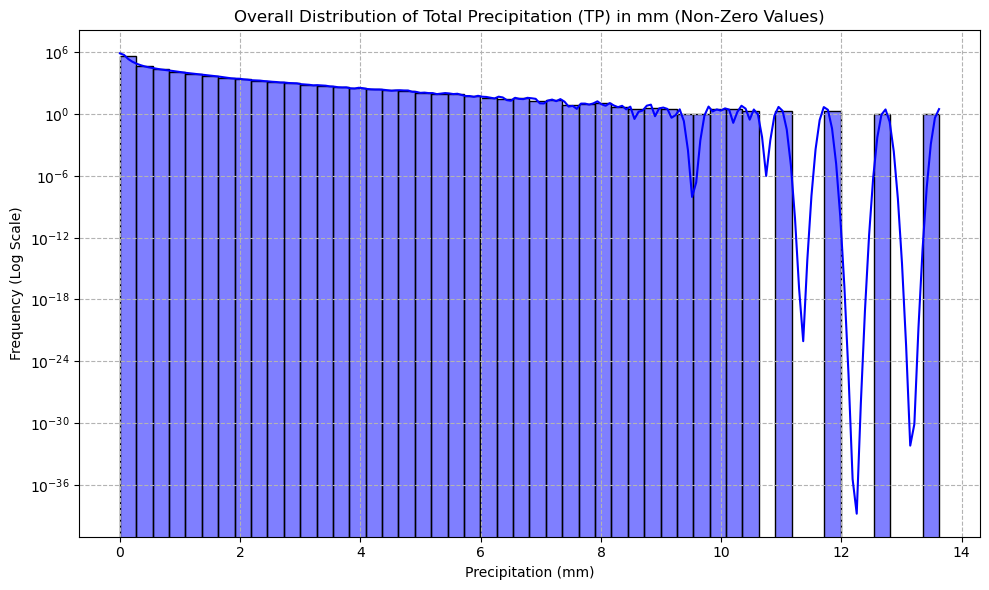

Overall TP (mm) - Min: 0.0, Max: 13.622283935546875, Median: 0.00762939453125
Percentage of zero precipitation values: 36.36%


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure 'valid_time' is a proper datetime index if it's not already
if not isinstance(df.index, pd.MultiIndex) or 'valid_time' not in df.index.names:
    # If df is not multi-indexed by valid_time, latitude, longitude
    # Or if valid_time is not a datetime type, convert it.
    # This step might vary depending on how df was created from ds
    # Assuming valid_time is already the first level of the MultiIndex:
    df.index = df.index.set_levels(pd.to_datetime(df.index.levels[0]), level='valid_time')


# Convert 'tp' from meters to millimeters
df['tp_mm'] = df['tp'] * 1000

# Handle potential negative values (if any result from conversion/interpolation)
df['tp_mm'][df['tp_mm'] < 0] = 0

# You might want to drop rows with NaNs for some variables for analysis
# For 'tp_mm', NaNs are less common if original 'tp' was always a number
# For other variables like 'mwd', 'mwp', 'swh', 'sst', many NaNs exist.
# Example: df_clean = df.dropna(subset=['tp_mm', 'u10', 'v10', 't2m'])

plt.figure(figsize=(10, 6))
# Filter for non-zero precipitation for a clearer view of actual rainfall events
sns.histplot(df['tp_mm'][df['tp_mm'] > 0], bins=50, kde=True, color='blue')
plt.title('Overall Distribution of Total Precipitation (TP) in mm (Non-Zero Values)')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log') # Use log scale for y-axis to better visualize skewed data
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()

print(f"Overall TP (mm) - Min: {df['tp_mm'].min()}, Max: {df['tp_mm'].max()}, Median: {df['tp_mm'].median()}")
print(f"Percentage of zero precipitation values: {np.mean(df['tp_mm'] == 0) * 100:.2f}%")



# Train/test split

In [9]:
df_reset = df_cleaned.reset_index()

# Convert 'valid_time' to datetime
df_reset['valid_time'] = pd.to_datetime(df_reset['valid_time'])

# Sort by time, then latitude, then longitude to ensure consistent grid formation
df_sorted = df_reset.sort_values(by=['valid_time', 'latitude', 'longitude'])

# Re-set the MultiIndex for easier handling, though we might iterate through it
df_final = df_sorted.set_index(['valid_time', 'latitude', 'longitude'])

print("DataFrame after sorting and re-indexing (first few rows):")
print(df_final.head())
print(f"Original shape: {df_final.shape}")



DataFrame after sorting and re-indexing (first few rows):
                                        number expver       u10       v10  \
valid_time          latitude longitude                                      
2002-01-01 12:00:00 45.0     5.00            0   0001 -0.804764 -1.102310   
                             5.25            0   0001 -0.738358 -0.229263   
                             5.50            0   0001 -0.763748  0.397690   
                             5.75            0   0001 -1.006912  0.909409   
                             6.00            0   0001 -1.389725  0.598862   

                                               d2m         t2m         msl  \
valid_time          latitude longitude                                       
2002-01-01 12:00:00 45.0     5.00       267.758881  274.061951  103693.125   
                             5.25       266.268646  273.729919  103658.125   
                             5.50       265.891693  271.888123  103644.625   
            

In [10]:
# --- 2. Determine Grid Dimensions ---
# Get unique latitudes and longitudes
latitudes = df_final.index.get_level_values('latitude').unique().sort_values()
longitudes = df_final.index.get_level_values('longitude').unique().sort_values()

num_lat = len(latitudes)
num_lon = len(longitudes)
num_features = len(df_final.columns) # All columns are features except if we designate one as target later

print(f"\nGrid dimensions: Latitude={num_lat}, Longitude={num_lon}")
print(f"Number of features (variables): {num_features}")



Grid dimensions: Latitude=41, Longitude=61
Number of features (variables): 9


In [11]:
# --- 3. Reshape to Gridded Data (Time, Lat, Lon, Features) ---
# Get all unique timestamps
all_times = df_final.index.get_level_values('valid_time').unique().sort_values()
num_times = len(all_times)

# Create an empty array to store the gridded data
# Shape: (num_times, num_lat, num_lon, num_features)
gridded_data = np.full((num_times, num_lat, num_lon, num_features), np.nan) # Use nan for missing spots

# Map latitude and longitude to array indices
lat_to_idx = {lat: i for i, lat in enumerate(latitudes)}
lon_to_idx = {lon: i for i, lon in enumerate(longitudes)}

# Populate the gridded_data array
for t_idx, time in enumerate(all_times):
    # Select data for the current timestamp
    time_slice_df = df_final.loc[time]

    for (lat, lon), row_data in time_slice_df.iterrows():
        lat_idx = lat_to_idx[lat]
        lon_idx = lon_to_idx[lon]
        gridded_data[t_idx, lat_idx, lon_idx, :] = row_data.values

print(f"\nShape of gridded_data: {gridded_data.shape}")
# Check if there are any NaNs left from this reshaping.
# There shouldn't be if all combinations of lat/lon exist for each time.
print(f"NaNs in gridded data after initial reshape: {np.sum(np.isnan(gridded_data))}")



Shape of gridded_data: (365, 41, 61, 9)
NaNs in gridded data after initial reshape: 0


In [12]:
# --- 4. Define Input (X) and Target (y) Variables ---
# 'tp' is total precipitation, which we want to predict.
# Let's find its column index.
feature_names = df_final.columns.tolist()
tp_col_idx = feature_names.index('tp')


In [13]:
# --- 5. Create Sequences for ConvLSTM ---
# We need to define:
# - `n_steps_in`: how many past time steps to use as input
# - `n_steps_out`: how many future time steps to predict (for rainfall, often 1)

n_steps_in = 3  # Example: Use the past 3 time steps (e.g., 3 days if data is daily)
n_steps_out = 1 # Example: Predict the next 1 time step (e.g., next day's rainfall)

def create_sequences(data, n_steps_in, n_steps_out, tp_idx):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        # Input sequence (all features except 'tp' for n_steps_in)
        # We need to exclude 'tp' from the input features
        X_seq_features = np.delete(data[i:(i + n_steps_in)], tp_idx, axis=-1)
        X.append(X_seq_features)

        # Output sequence (only 'tp' for n_steps_out)
        y_seq_tp = data[(i + n_steps_in):(i + n_steps_in + n_steps_out), :, :, tp_idx]
        y.append(y_seq_tp)
    return np.array(X), np.array(y)

X_sequences, y_sequences = create_sequences(gridded_data, n_steps_in, n_steps_out, tp_col_idx)

print(f"\nShape of X_sequences (input): {X_sequences.shape}")
print(f"Shape of y_sequences (target): {y_sequences.shape}")

# X_sequences shape should be (num_samples, n_steps_in, num_lat, num_lon, num_features - 1)
# y_sequences shape should be (num_samples, n_steps_out, num_lat, num_lon) - if predicting one variable




Shape of X_sequences (input): (362, 3, 41, 61, 8)
Shape of y_sequences (target): (362, 1, 41, 61)


In [14]:
# --- 6. Time-based Train-Test Split ---
# The data covers 2002. Let's use the first ~9 months for training and the last ~3 months for testing.
# A common split is 80% train / 20% test.
# Since X_sequences and y_sequences are already ordered by time, we can simply split the arrays.

# Determine the split point based on the number of sequences
split_ratio = 0.8
split_index = int(len(X_sequences) * split_ratio)

X_train = X_sequences[:split_index]
y_train = y_sequences[:split_index]
X_test = X_sequences[split_index:]
y_test = y_sequences[split_index:]

print(f"\nTraining set size: {len(X_train)} sequences")
print(f"Test set size: {len(X_test)} sequences")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



Training set size: 289 sequences
Test set size: 73 sequences
X_train shape: (289, 3, 41, 61, 8)
y_train shape: (289, 1, 41, 61)
X_test shape: (73, 3, 41, 61, 8)
y_test shape: (73, 1, 41, 61)


# Normalisation

In [15]:
original_feature_names_in_X_sequences = [col for col in df_final.columns if col != 'tp']


print(f"Features (channels) in X_sequences before normalization: {original_feature_names_in_X_sequences}")
print(f"Number of features (channels) in X_sequences: {len(original_feature_names_in_X_sequences)}")


Features (channels) in X_sequences before normalization: ['number', 'expver', 'u10', 'v10', 'd2m', 't2m', 'msl', 'sp']
Number of features (channels) in X_sequences: 8


In [16]:
# --- 1. Identify and Exclude Constant Features (if any) ---
# This step should ideally be done BEFORE creating X_sequences.
# Let's check for constants in the original `df_final` used to create the gridded data.
# If df_final is not available, you would need to load a sample or assume.

constant_features_found = []
if 'df_final' in locals():
    # Check only features that ended up in X_sequences
    for col in original_feature_names_in_X_sequences:
        if df_final[col].nunique() == 1:
            constant_features_found.append(col)
            print(f"Warning: Feature '{col}' is constant and will not be effectively normalized by RobustScaler.")
            print(f"It's generally recommended to remove constant features before creating sequences if they are truly constant.")
else:
    print("Warning: `df_final` not found. Cannot verify if features are constant.")


It's generally recommended to remove constant features before creating sequences if they are truly constant.
It's generally recommended to remove constant features before creating sequences if they are truly constant.


In [17]:
# --- 2. Normalization of X_train and X_test features ---

# Get the shape of X_train to reshape back later
shape_x_train = X_train.shape # (num_samples, n_steps_in, num_lat, num_lon, num_features_for_scaling)
num_features_for_scaling = shape_x_train[-1] # Number of channels (e.g., 8)

# Flatten X_train for scaler fitting: (total_elements, num_features)
# This combines all samples, timesteps, lat, and lon into a single dimension for feature scaling
X_train_reshaped_for_scaler = X_train.reshape(-1, num_features_for_scaling)
print(f"\nX_train reshaped for scaler fitting: {X_train_reshaped_for_scaler.shape}")

# Initialize RobustScaler for features
scaler_X = RobustScaler()

# Fit the scaler ONLY on the training data's reshaped features
scaler_X.fit(X_train_reshaped_for_scaler)
print("\nRobustScaler for features (X) fitted on X_train data.")

# Transform both training and test data using the fitted scaler
X_train_normalized_reshaped = scaler_X.transform(X_train_reshaped_for_scaler)
X_test_normalized_reshaped = scaler_X.transform(X_test.reshape(-1, num_features_for_scaling)) # Reshape X_test on the fly

print(f"X_train normalized reshaped shape: {X_train_normalized_reshaped.shape}")
print(f"X_test normalized reshaped shape: {X_test_normalized_reshaped.shape}")

# Reshape the normalized data back to the ConvLSTM input format (5D)
X_train_normalized = X_train_normalized_reshaped.reshape(shape_x_train)
X_test_normalized = X_test_normalized_reshaped.reshape(X_test.shape) # Use X_test's original shape

print(f"\nFinal X_train_normalized shape (ready for ConvLSTM input): {X_train_normalized.shape}")
print(f"Final X_test_normalized shape (ready for ConvLSTM input): {X_test_normalized.shape}")




X_train reshaped for scaler fitting: (2168367, 8)

RobustScaler for features (X) fitted on X_train data.
X_train normalized reshaped shape: (2168367, 8)
X_test normalized reshaped shape: (547719, 8)

Final X_train_normalized shape (ready for ConvLSTM input): (289, 3, 41, 61, 8)
Final X_test_normalized shape (ready for ConvLSTM input): (73, 3, 41, 61, 8)


In [18]:
# --- 3. Normalization for the Target Variable (y - Total Precipitation 'tp') ---
# 'tp' values are non-negative and often have a high concentration at zero, with some large values.
# RobustScaler can work, but consider alternatives like log1p if zeros are dominant and you want to reduce skewness.

# Get the shape of y_train to reshape back later
shape_y_train = y_train.shape # (num_samples, n_steps_out, num_lat, num_lon)
num_features_y = 1 # 'tp' is a single target variable

# Flatten y_train for scaler fitting: (total_elements, 1)
y_train_reshaped_for_scaler = y_train.reshape(-1, num_features_y)
print(f"\ny_train reshaped for scaler fitting: {y_train_reshaped_for_scaler.shape}")

quantile_transformer_y = QuantileTransformer(output_distribution='normal',
                                             n_quantiles=max(10, min(y_train_reshaped_for_scaler.shape[0], 1000)),
                                             random_state=42) # For reproducibility

# Fit the transformer ONLY on the training data's reshaped target
quantile_transformer_y.fit(y_train_reshaped_for_scaler) # <--- REPLACED 'scaler_y.fit(...)'
print("QuantileTransformer for target (y/tp) fitted on y_train data.")

# Transform both training and test target data
y_train_normalized_reshaped = quantile_transformer_y.transform(y_train_reshaped_for_scaler) # <--- REPLACED 'scaler_y.transform(...)'
y_test_normalized_reshaped = quantile_transformer_y.transform(y_test.reshape(-1, num_features_y)) # <--- REPLACED 'scaler_y.transform(...)'

y_train_normalized = y_train_normalized_reshaped.reshape(shape_y_train)
y_test_normalized = y_test_normalized_reshaped.reshape(y_test.shape)

print(f"Final y_train_normalized shape (ready for ConvLSTM output): {y_train_normalized.shape}")
print(f"Final y_test_normalized shape (ready for ConvLSTM output): {y_test_normalized.shape}")




y_train reshaped for scaler fitting: (722789, 1)
QuantileTransformer for target (y/tp) fitted on y_train data.
Final y_train_normalized shape (ready for ConvLSTM output): (289, 1, 41, 61)
Final y_test_normalized shape (ready for ConvLSTM output): (73, 1, 41, 61)


# Training

In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import Huber


# Ensure TensorFlow is using a GPU if available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU for training.")
else:
    print("No GPU found. Training on CPU.")

# --- Define Model Parameters based on your data ---
# These values should come from your previous data preparation steps
# For demonstration purposes, I'll use placeholders if not defined globally.
# In a continuous script, these would already be in scope.

# Example values (replace with your actual data shapes from previous steps)
# from the previous notebook section
# X_train_normalized shape: (num_train_samples, n_steps_in, num_lat, num_lon, num_predictor_features)
# y_train_normalized shape: (num_train_samples, n_steps_out, num_lat, num_lon)

# Assume these are available from the previous run:
# X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized

# Infer dimensions from your normalized data
n_samples_train, n_steps_in, num_lat, num_lon, num_channels = X_train_normalized.shape
_, n_steps_out, _, _ = y_train_normalized.shape # Assuming y_train_normalized has 4 dimensions

print(f"\nModel Input Parameters:")
print(f"  n_steps_in (sequence length): {n_steps_in}")
print(f"  num_lat (grid rows): {num_lat}")
print(f"  num_lon (grid columns): {num_lon}")
print(f"  num_channels (input features): {num_channels}")
print(f"  n_steps_out (prediction horizon): {n_steps_out}")

# --- Adjust y_train_normalized/y_test_normalized if n_steps_out is 1 ---
# Keras ConvLSTM2D output can be a sequence or just the last step.
# If n_steps_out is 1, it's common to predict a single frame.
# The target `y` should match the model's output shape.
if n_steps_out == 1:
    # Squeeze the n_steps_out dimension from y if it's 1, as the model's Conv3D output will be 3D.
    # From (samples, 1, lat, lon) to (samples, lat, lon)
    y_train_target = y_train_normalized.squeeze(axis=1)
    y_test_target = y_test_normalized.squeeze(axis=1)
    print(f"Target 'y' adjusted from {y_train_normalized.shape} to {y_train_target.shape} for n_steps_out=1.")
else:
    y_train_target = y_train_normalized
    y_test_target = y_test_normalized
    print(f"Target 'y' shape remains {y_train_target.shape} as n_steps_out > 1.")

# --- Build the ConvLSTM Model ---

model = Sequential()

model.add(ConvLSTM2D(filters=64, kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     return_sequences=True,
                     input_shape=(n_steps_in, num_lat, num_lon, num_channels)))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                     activation='relu',
                     padding='same',
                     return_sequences=False))
model.add(BatchNormalization())


model.add(Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same'))

if n_steps_out == 1:
    model.add(Lambda(lambda x: tf.squeeze(x, axis=-1)))

# --- Compile the Model ---
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae', 'mse'])

model.summary()

# --- Define Callbacks for Training ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_convlstm_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   verbose=1)

# --- Train the Model ---
print("\nStarting model training...")
history = model.fit(X_train_normalized, y_train_target,
                    epochs=50,
                    batch_size=5,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

print("\nModel training complete.")

# --- Evaluate the Model on the Test Set ---
print("\nEvaluating model on the test set...")
test_loss_msle, test_mae, test_mse = model.evaluate(X_test_normalized, y_test_target, verbose=1) 
print(f"Test Loss (Huber): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")


# You can now use the trained `model` to make predictions:
# predictions_normalized = model.predict(X_test_normalized)
# Then inverse transform `predictions_normalized` using `scaler_y` to get original precipitation values.


Num GPUs Available:  0
No GPU found. Training on CPU.

Model Input Parameters:
  n_steps_in (sequence length): 3
  num_lat (grid rows): 41
  num_lon (grid columns): 61
  num_channels (input features): 8
  n_steps_out (prediction horizon): 1
Target 'y' adjusted from (289, 1, 41, 61) to (289, 41, 61) for n_steps_out=1.


/Users/ahmed.shaikh/miniforge3/envs/srsi/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 3, 41, 61, 64)  │       461,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 41, 61, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 41, 61, 64)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 41, 61, 1)      │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 41, 61)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,801 (2.89 MB)

 Trainable params: 756,545 (2.89 MB)

 Non-trainable params: 256 (1.00 KB)


Starting model training...
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - loss: 2.0006 - mae: 2.4344 - mse: 10.1777
Epoch 1: val_loss improved from inf to 1.69487, saving model to best_convlstm_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 699ms/step - loss: 1.9999 - mae: 2.4336 - mse: 10.1730 - val_loss: 1.6949 - val_mae: 2.1177 - val_mse: 8.1463
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - loss: 1.7680 - mae: 2.1921 - mse: 8.5432
Epoch 2: val_loss did not improve from 1.69487
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 706ms/step - loss: 1.7685 - mae: 2.1926 - mse: 8.5448 - val_loss: 1.7114 - val_mae: 2.1534 - val_mse: 7.8841
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - loss: 1.7096 - mae: 2.1360 - mse: 7.9484
Epoch 3: val_loss did not improve from 1.69487
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 678ms/step - loss: 1.7098 - mae: 2.1362 - mse: 7.9499 - val_loss: 1.7122 - val_mae: 2.1828 - val_mse: 7.1682
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - loss: 1.6433 - mae: 2.0698 - mse: 7.7282
Epoch 4: val_loss did not improve from 1.69487
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 684ms/step - loss: 1.6441 - mae: 2.0706 - mse: 7.7305 - val_loss: 1.7615 - val_mae: 2.2437 - val_mse: 7.1273
Epoch 5/50
47

47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 681ms/step - loss: 1.6537 - mae: 2.0814 - mse: 7.5210 - val_loss: 1.6903 - val_mae: 2.1663 - val_mse: 6.7297
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - loss: 1.6713 - mae: 2.0988 - mse: 7.7892
Epoch 6: val_loss improved from 1.69035 to 1.62185, saving model to best_convlstm_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 678ms/step - loss: 1.6703 - mae: 2.0977 - mse: 7.7847 - val_loss: 1.6219 - val_mae: 2.0788 - val_mse: 6.6217
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - loss: 1.4792 - mae: 1.8950 - mse: 6.7552
Epoch 7: val_loss improved from 1.62185 to 1.56166, saving model to best_convlstm_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 679ms/step - loss: 1.4804 - mae: 1.8961 - mse: 6.7627 - val_loss: 1.5617 - val_mae: 1.9894 - val_mse: 6.9152
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - loss: 1.5888 - mae: 2.0147 - mse: 7.2635
Epoch 8: val_loss did not improve from 1.56166
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 676ms/step - loss: 1.5883 - mae: 2.0141 - mse: 7.2624 - val_loss: 1.6324 - val_mae: 2.0713 - val_mse: 7.1538
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - loss: 1.5237 - mae: 1.9388 - mse: 7.1078
Epoch 9: val_loss did not improve from 1.56166
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 682ms/step - loss: 1.5236 - mae: 1.9387 - mse: 7.1070 - val_loss: 1.5659 - val_mae: 1.9903 - val_mse: 6.9461
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - loss: 1.5036 - mae: 1.9218 - mse: 6.9319
Epoch 10: val_loss did not improve from 1.56166
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 684ms/step - loss: 1.5028 - mae: 1.9210 - mse: 6.9295 - val_loss: 1.6383 - val_mae: 2.0642 - val_mse: 7.4460
Epoch 11/50


NameError: name 'test_loss' is not defined

# Prediction

## Redefining the model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Lambda
import tensorflow.keras.backend as K # Import Keras backend for the Lambda layer

# Parameters from your original training summary
n_steps_in = 7
num_lat = 41 # grid rows
num_lon = 61 # grid columns
num_channels = 8 # input features
n_output_features = num_lat * num_lon # This parameter isn't directly used in the Dense layer anymore,
                                     # but the output shape of the model will be (None, num_lat, num_lon)

# Re-define your model architecture to exactly match the original summary
model = Sequential([
    # First ConvLSTM2D block
    ConvLSTM2D(filters=64, kernel_size=(5, 5), activation='relu',
               input_shape=(n_steps_in, num_lat, num_lon, num_channels), # Note: input_shape is (timesteps, rows, cols, channels)
               padding='same', return_sequences=True, name='conv_lstm2d_6'),
    BatchNormalization(name='batch_normalization_6'),

    # Second ConvLSTM2D block (return_sequences=False to collapse time dimension)
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu',
               padding='same', return_sequences=False, name='conv_lstm2d_7'),
    BatchNormalization(name='batch_normalization_7'),

    # Final Conv2D layer to output the 2D map with a single channel
    Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same', name='conv2d_2'),

    # Lambda layer to squeeze the last dimension (channel dimension)
    Lambda(lambda x: K.squeeze(x, axis=-1), name='lambda_2')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Load the saved weights
weights_path = 'best_convlstm_model.h5' # Make sure this path is correct
try:
    model.load_weights(weights_path)
    print("Model weights loaded successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Please ensure the model architecture exactly matches the saved model and the path is correct.")

# You can now verify the loaded model's summary
model.summary()


Model weights loaded successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 7, 41, 61, 64)  │       461,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 41, 61, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 41, 61, 64)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 41, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 61, 1)      │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 41, 61)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,801 (2.89 MB)

 Trainable params: 756,545 (2.89 MB)

 Non-trainable params: 256 (1.00 KB)

In [21]:
predictions_normalized = model.predict(X_test_normalized)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 832ms/step


In [32]:
# Assuming 'quantile_transformer_y' is your fitted QuantileTransformer object from the normalization step
# Ensure it's accessible in this scope.

num_samples, lat, lon = predictions_normalized.shape

# Reshape predictions_normalized for inverse transformation (needs 2D: (n_samples, n_features))
# Here, n_features is 1, as each lat*lon point is an individual "feature" in the flattened array.
predictions_normalized_reshaped_2d = predictions_normalized.reshape(-1, 1)

# Apply the inverse transformation using quantile_transformer_y
preds_inversed_reshaped_2d = quantile_transformer_y.inverse_transform(predictions_normalized_reshaped_2d) # <--- REPLACED THIS LINE

# Reshape back to the original spatial dimensions
preds_inversed = preds_inversed_reshaped_2d.reshape(num_samples, lat, lon)

# If your original 'tp' was in meters, preds_inversed is now in meters.
# Multiply by 1000 to get millimeters for pred_rainfall_mm.
pred_rainfall_mm = preds_inversed * 1000

# Ensure no negative rainfall values (physical constraint)
pred_rainfall_mm[pred_rainfall_mm < 0] = 0


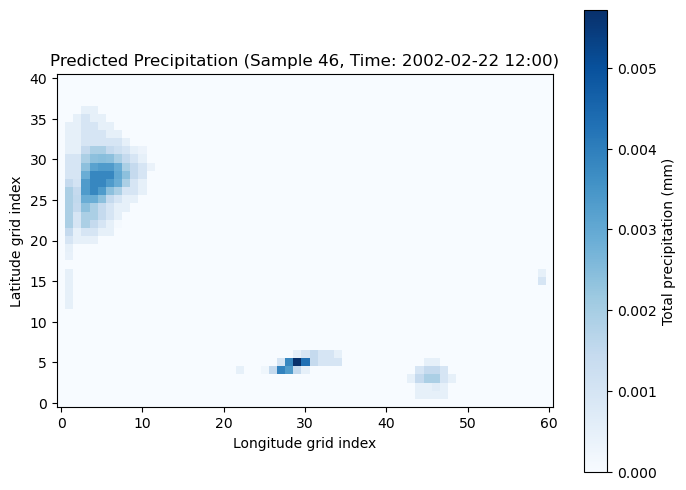

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Select sample index to plot
sample_idx = 46

timestamp = all_times[sample_idx +n_steps_in -1]

pred_to_plot = pred_rainfall_mm[sample_idx]  # shape (lat, lon)

plt.figure(figsize=(8, 6))


plt.imshow(pred_to_plot, origin='lower', cmap='Blues')
plt.colorbar(label='Total precipitation (mm)')
plt.title(f'Predicted Precipitation (Sample {sample_idx}, Time: {pd.to_datetime(timestamp).strftime("%Y-%m-%d %H:%M")})')
plt.xlabel('Longitude grid index')
plt.ylabel('Latitude grid index')
plt.show()


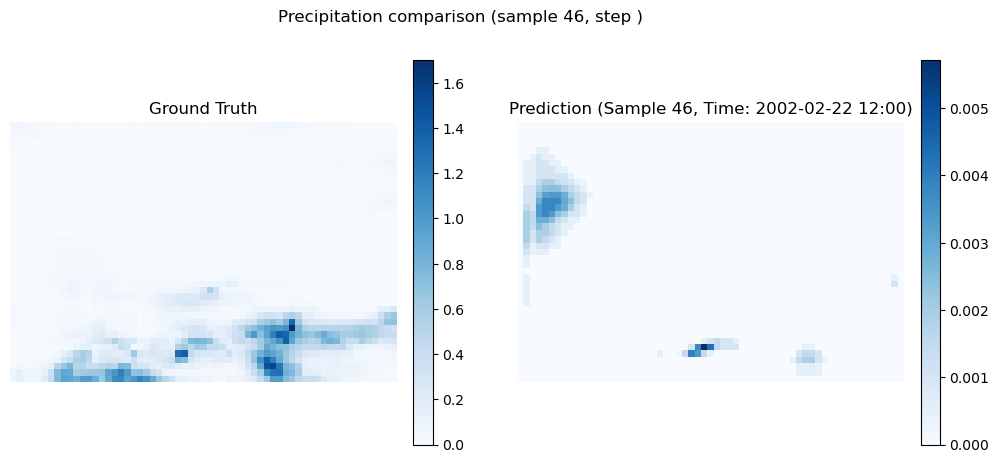

Predictions Normalized - Min: -8.651994705200195, Max: 4.097925186157227
Ground Truth Normalized - Min: -5.199337582605575, Max: 3.413891129364391
Predictions Inversed (meters) - Min: 0.0, Max: 0.008400164544582367
Ground Truth Inversed (meters) - Min: 0.0, Max: 0.007279872894287116


In [49]:
# Reshape y_test_normalized for inverse transformation
y_test_reshaped_2d = y_test_normalized.reshape(-1, 1)

# Apply the inverse transformation using quantile_transformer_y
y_test_inversed_reshaped_2d = quantile_transformer_y.inverse_transform(y_test_reshaped_2d) # <--- REPLACED THIS LINE

# Reshape back to the original spatial dimensions
y_test_inversed = y_test_inversed_reshaped_2d.reshape(y_test_normalized.shape[0], num_lat, num_lon)

# If your original 'tp' was in meters, y_test_inversed is now in meters.
# Multiply by 1000 to get millimeters for true_rainfall_mm.
true_rainfall_mm = y_test_inversed * 1000
true_rainfall_mm[true_rainfall_mm < 0] = 0

import matplotlib.pyplot as plt

if n_steps_out == 1:
    pred_to_plot = pred_rainfall_mm[sample_idx]
    true_to_plot = true_rainfall_mm[sample_idx]
else:
    pred_to_plot = pred_rainfall_mm[sample_idx, time_step]
    true_to_plot = true_rainfall_mm[sample_idx, time_step] 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(true_to_plot, origin='lower', cmap='Blues')
axes[0].set_title('Ground Truth')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(pred_to_plot, origin='lower', cmap='Blues')
axes[1].set_title(f'Prediction (Sample {sample_idx}, Time: {pd.to_datetime(timestamp).strftime("%Y-%m-%d %H:%M")})')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle(f'Precipitation comparison (sample {sample_idx}, step {time_step if n_steps_out > 1 else ""})')
plt.show()

# In the cell where predictions_normalized is available:
print(f"Predictions Normalized - Min: {predictions_normalized.min()}, Max: {predictions_normalized.max()}")

# In the cell where y_test_normalized is available:
print(f"Ground Truth Normalized - Min: {y_test_normalized.min()}, Max: {y_test_normalized.max()}")

# In the cell with pred_rainfall_mm (before the * 1000 line):
print(f"Predictions Inversed (meters) - Min: {preds_inversed.min()}, Max: {preds_inversed.max()}")

# In the cell with true_rainfall_mm (before the * 1000 line):
print(f"Ground Truth Inversed (meters) - Min: {y_test_inversed.min()}, Max: {y_test_inversed.max()}")


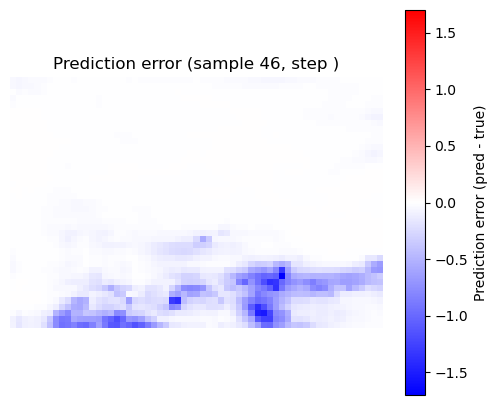

In [50]:
error_map = pred_to_plot - true_to_plot

timestamp = all_times[sample_idx + n_steps_in - 1]

plt.figure(figsize=(6, 5))
plt.imshow(error_map, origin='lower', cmap='bwr', vmin=-abs(error_map).max(), vmax=abs(error_map).max())
plt.colorbar(label='Prediction error (pred - true)')
plt.title(f'Prediction error (sample {sample_idx}, step {time_step if n_steps_out > 1 else ""})')
plt.axis('off')
plt.show()
